In [2]:
import cv2         #openCV
import numpy as np
import tifffile    # to read stacked tiff file
import glob        # to grab all files in folder
import os          # to help move you in the correct directory
import math
from matplotlib import pyplot as plt, figure # for plotting
from skimage import exposure        # for increasing brightness, rescales image
from PIL import Image, ImageDraw, ImageFilter # for making composite image
import pandas as pd
import datetime
#import the following extra files which should be in the same folder as MAIN
from extract_Circles import  get_Circles, image_Prep, get_ROI, multiple_dfs, sub_Matrix, make_CV2image
%matplotlib inline

In [26]:
directory = r'C:/Users/JoshuaBishop/GH+ Labs/Digital Assay Feasibility - Documents/General/Data/Interns/Lael W/20210723 Khe Concentration curve in droplets and bulk/Images'
replicates = 1
imagingChannels = ['BF', 'QD575']
showImage = 0  # 0 = no don't show, 1  = yes please show images!
saveToExcel = 1 # 0 = no don't save, 1 = yes please save to excel!
thresholdTrue = 0 # 0 = don't do the thresholding analysis placeholder
compositeSave = 0 # 0 = don't create and show composite images
thresholds = [.26] # choose threshold manually, I may change to automatic later, based on neg data
path = directory + '/*.tif'
os.chdir(directory)
filenames = glob.glob(path)
filenames.sort()
allImages = []
allPositive = np.empty([])

In [27]:
i = 1
img = tifffile.imread(filenames[i])
img_name = filenames[i][filenames[i].find('\\')+1:filenames[i].find('.tif')]
img_BF = img[:,:,0]
img_QD = img[:,:,1]
img_name

'H2_10e4copies'

In [5]:
img_adj = image_Prep(img_BF, 'BF', img_name, showImage)

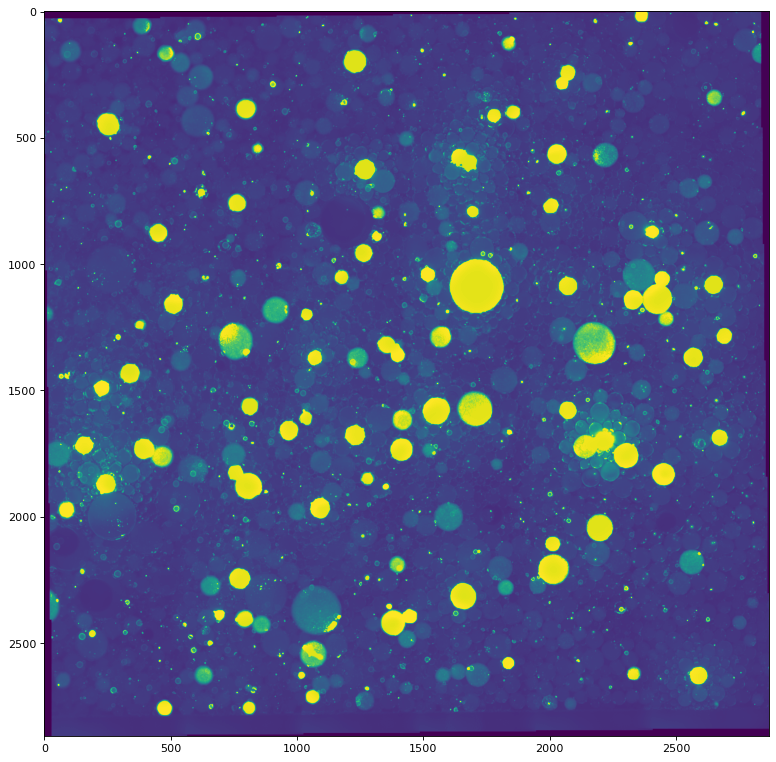

In [221]:
plt.figure(figsize=(12,12), dpi=80)
plt.imshow(img_QD)

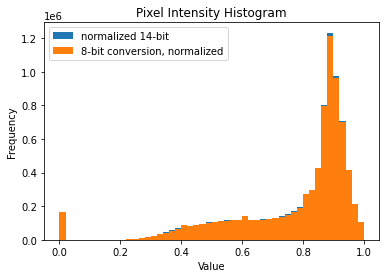

In [213]:
plt.title("Pixel Intensity Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.hist((img_BF/(2**14-1)).flatten(), bins = 50, label = 'normalized 14-bit')
plt.hist((img_adj/(2**8-1)).flatten(), bins = 50, label = '8-bit conversion, normalized')
plt.legend()
plt.show()

In [214]:
(img_BF/(2**14-1)).flatten().sum()-(img_adj/(2**8-1)).flatten().sum()

68.55472495406866

In [8]:

img_8bit = cv2.convertScaleAbs(img_BF,alpha =(255.0/16383.0))
cv2.imshow("test",img_8bit)
cv2.waitKey(0)
cv2.destroyAllWindows()

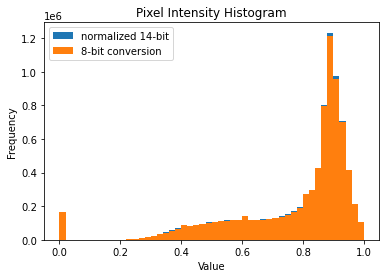

In [217]:
plt.title("Pixel Intensity Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.hist((img_BF/(2**14-1)).flatten(), bins = 50, label = 'normalized 14-bit')
plt.hist(np.array(img_8bit/255.0).flatten(), bins = 50, label = '8-bit conversion')
plt.legend()
plt.show()

In [10]:
img_BF_8bit = cv2.convertScaleAbs(img_BF,alpha =(255.0/16383.0))
img_max = np.array(img.shape).max()
img_min = 0
circs = get_Circles(img_BF_8bit, 'BF', showImage)
rects = [[int(circ[0]-circ[2]/math.sqrt(2)*0.8), int(circ[1]-circ[2]/math.sqrt(2)*0.8), int(circ[2]*math.sqrt(2)*0.8)] for circ in circs]
rects = np.clip(rects, img_min, img_max)
rects

array([[2585, 1702,   17],
       [1050,  854,   25],
       [1984, 2722,   18],
       ...,
       [  60,  109,   12],
       [ 669,   94,   13],
       [1733,   64,   12]])

In [363]:
intensities = [np.mean(img_QD[rect[1]:rect[1]+rect[2],rect[0]:rect[0]+rect[2]]/255) for rect in rects]
def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

scale(intensities)

array([0.32568802, 0.15704287, 0.26482431, ..., 0.02743669, 0.02273333,
       0.03573798])

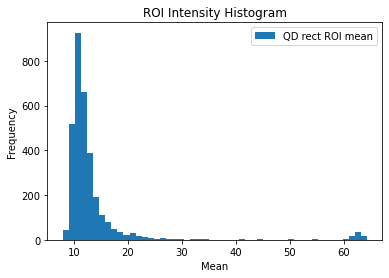

In [364]:
plt.title("ROI Intensity Histogram")
plt.xlabel("Mean")
plt.ylabel("Frequency")
plt.hist(intensities, bins = 50, label = 'QD rect ROI mean')
#plt.hist(img_QD.flatten(), bins = 50, label = 'QD rect ROI mean normalized')
plt.legend()
plt.show()

In [365]:
i = 1000
np.mean((img_QD/16383)[rects[i,0]:rects[i,0]+rects[i,2],rects[i,1]:rects[i,1]+rects[i,2]])
circs[i,2]

15.170151710510254

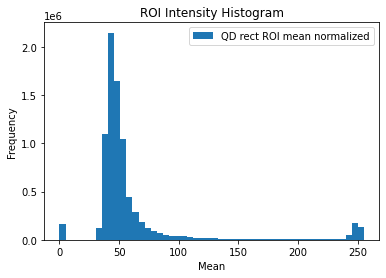

In [366]:
img_QD_8bit = cv2.convertScaleAbs(img_QD, alpha =(255.0/16383.0))

plt.title("ROI Intensity Histogram")
plt.xlabel("Mean")
plt.ylabel("Frequency")
plt.hist(img_QD_8bit.flatten(), bins = 50, label = 'QD rect ROI mean normalized')
plt.legend()
plt.show()

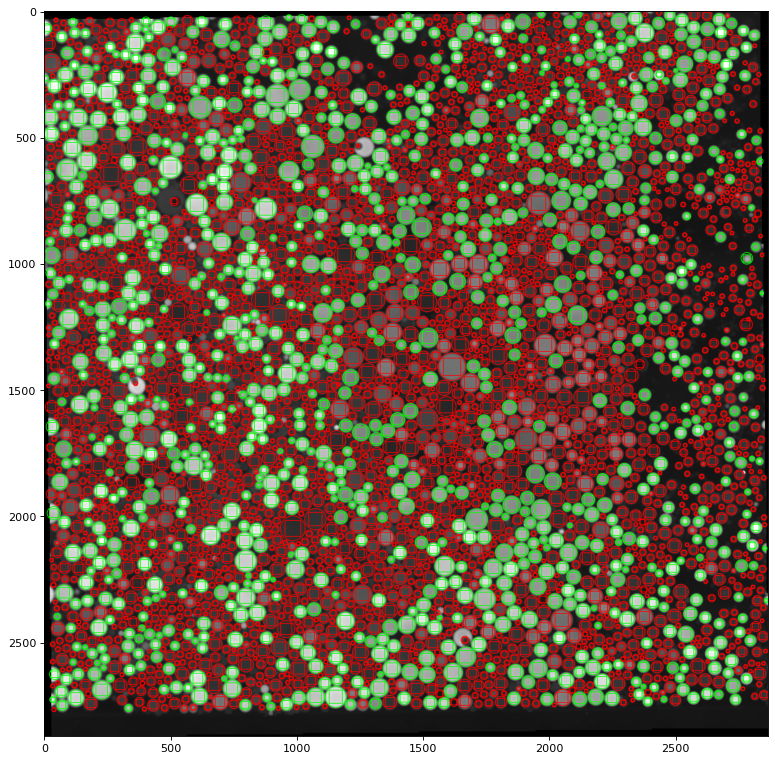

In [28]:
img_BF_8bit = cv2.convertScaleAbs(img_BF,alpha =(255.0/16383.0))
img_max = np.array(img.shape).max()
img_min = 0
circs = get_Circles(img_BF_8bit, 'BF', showImage)
rects_scalefactor = 0.9
rects = [[int(circ[0]-circ[2]/math.sqrt(2)*rects_scalefactor), int(circ[1]-circ[2]/math.sqrt(2)*rects_scalefactor), int(circ[2]*math.sqrt(2)*rects_scalefactor)] for circ in circs]
rects = np.clip(rects, img_min, img_max)
rects

img_input = cv2.convertScaleAbs(img_QD, alpha = (255/16383.0))
img_overlay = np.dstack((img_input, img_input, img_input))
#img_overlay = img_QD

# circs contains the (x, y, radius in pixels, radius in um, and estimated pL volume)
for circ, rect in zip(circs, rects):
    if np.mean(img_QD[rect[1]:rect[1]+rect[2],rect[0]:rect[0]+rect[2]])/16383 > 0.5:
        circ_color = (0, 255, 0)
    else:
        circ_color = (255, 0, 0)
    img_overlay = cv2.circle(img_overlay, (int(circ[0]), int(circ[1])), int(circ[2]), circ_color, 2)
    img_overlay = cv2.rectangle(img_overlay,(rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[2]), circ_color, 2)

#i = np.argmax(rects[:,2])
#img_overlay = cv2.rectangle(img_overlay,(rects[i, 0], rects[i, 1]), (rects[i, 0] + rects[i, 2], rects[i, 1] + rects[i, 2]), (255, 255, 0), 2)

plt.figure(figsize=(12,12), dpi=80)
#plt.imshow(img_overlay[rects[i,1]:rects[i,1]+rects[i,2],rects[i,0]:rects[i,0]+rects[i,2]])
plt.imshow(img_overlay)

In [368]:
rects[i]

array([1657, 1639,   17])

In [369]:
rects[np.argmax(rects[:,2])]

array([2134, 1275,   85])